# Step 1.: Dealing the cards

In [231]:
import os
import random
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import cv2
import numpy as np

def deal_hand_and_flop(base_path, num_cards_probs=[0.35, 0.40, 0.15, 0.10]):
    """
    Select the hand and flop card images based on the given rules.
    - base_path: Base path for card images.
    - num_cards_probs: Probabilities for selecting the number of cards [2, 5, 6, 7].
    Returns:
        hand_cards (list): List of paths for the hand cards.
        flop_cards (list): List of paths for the flop cards.
    """
    # Define card classes and number of cards to draw
    classes = [ '2C', '2D', '2H', '2S',
                '3C', '3D', '3H', '3S',
                '4C', '4D', '4H', '4S',
                '5C', '5D', '5H', '5S', 
                '6C', '6D', '6H', '6S', 
                '7C', '7D', '7H', '7S', 
                '8C', '8D', '8H', '8S', 
                '9C', '9D', '9H', '9S',
                'TC', 'TD', 'TH', 'TS', 
                'AC', 'AD', 'AH', 'AS', 
                'JC', 'JD', 'JH', 'JS',
                'KC', 'KD', 'KH', 'KS', 
                'QC', 'QD', 'QH', 'QS']
    num_cards_options = [2, 5, 6, 7]

    # Step 1: Randomly choose a deck
    deck = random.choice(["first", "second"])
    suffix = "_" if deck == "second" else ""

    #Constructing the bounding box for the yolo format (x_center, y_center, width, height)
    if deck == "first":
        b_boxes_yolo = [[66, 145, 100, 230], [625, 911, 100, 230], [345, 528, 691, 1056]]
    else:
        b_boxes_yolo = [[45, 90, 90, 180], [455, 636, 90, 180], [250, 363, 500, 726]]
    

    # Step 2: Shuffle and draw a random number of cards
    random.shuffle(classes)
    num_cards = random.choices(num_cards_options, weights=num_cards_probs, k=1)[0]
    selected_classes = classes[:num_cards]

    hand_labels = [[card, b_boxes_yolo] for card in selected_classes[:2]]
    flop_labels = [[card, b_boxes_yolo] for card in selected_classes[2:]]

    # Step 3: Generate file paths for the selected cards
    hand_paths = [os.path.join(base_path, f"{suffix}{card}.png") for card in selected_classes[:2]]
    flop_paths = [os.path.join(base_path, f"{suffix}{card}.png") for card in selected_classes[2:]]

    return hand_paths, flop_paths, hand_labels, flop_labels

In [232]:
def yolo_notation2cv2_notation(yolo_notation):
    x, y, w, h = yolo_notation
    #Upper left
    x1 = int(x - w / 2)
    y1 = int(y - h / 2)
    #Upper right
    x2 = x1 + w
    y2 = y1
    #Lower right
    x3 = x2
    y3 = y1 + h
    #Lower left
    x4 = x1
    y4 = y3

    return np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])

def cv2_notation2yolo_notation(cv2_notation):
    x1, y1 = cv2_notation[0]
    x3, y3 = cv2_notation[2]
    
    #Width and height
    w = x3 - x1
    h = y3 - y1

    #Center
    x = x1 + w / 2
    y = y1 + h / 2
    
    return x, y, w, h

def cv2_modified2yolo_notation(cv2_modified):
    # Extract the x and y coordinates from the points
    x_coords = cv2_modified[:, 0]
    y_coords = cv2_modified[:, 1]

    # Calculate the center
    x_center = sum(x_coords) / 4
    y_center = sum(y_coords) / 4

    # Calculate the width and height
    width = max(x_coords) - min(x_coords)
    height = max(y_coords) - min(y_coords)

    return x_center, y_center, width, height

Here is an example of what the first function does

Hand cards:  [['9C', [[45, 90, 90, 180], [455, 636, 90, 180], [250, 363, 500, 726]]], ['2C', [[45, 90, 90, 180], [455, 636, 90, 180], [250, 363, 500, 726]]]]


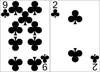

Flop cards: None


In [233]:
from IPython.display import display

benchmarks_path = "../shared_data/benchmark"
hand_paths, flop_paths, hand_labels, flop_labels = deal_hand_and_flop(benchmarks_path)

# Convert cv2 images to PIL images
hand = [Image.open(path).convert("RGBA") for path in hand_paths]
flop = [Image.open(path).convert("RGBA") for path in flop_paths]
hand = [card.resize((int(card.width * 0.1), int(card.height * 0.1))) for card in hand]
flop = [card.resize((int(card.width * 0.1), int(card.height * 0.1))) for card in flop]

# Display hand cards next to each other
hand_combined = Image.new("RGBA", (hand[0].width * len(hand), hand[0].height))
for i, card in enumerate(hand):
    hand_combined.paste(card, (i * card.width, 0))
print("Hand cards: ", hand_labels)
display(hand_combined)

# Display flop cards next to each other
if flop:
    flop_combined = Image.new("RGBA", (flop[0].width * len(flop), flop[0].height))
    for i, card in enumerate(flop):
        flop_combined.paste(card, (i * card.width, 0))
    print("Flop cards: ", flop_labels)
    display(flop_combined)
else:
    print("Flop cards: None")

## Step 1.1: Auxiliary functions

In [234]:
# hand_paths, flop_paths, hand_labels, flop_labels = deal_hand_and_flop(benchmarks_path)
# hand = cv2.cvtColor(cv2.imread(hand_paths[0]), cv2.COLOR_BGR2RGBA)
# # Display just one card

# plt.imshow(hand)
# plt.axis('off')
# # # Display hand cards next to each other
# # hand_combined = Image.new("RGBA", (hand[0].width * len(hand), hand[0].height))
# # for i, card in enumerate(hand):
# #     hand_combined.paste(card, (i * card.width, 0))
# # display(hand_combined)



### Independent rotation of the single images

In [235]:
def rotate_image(image, b_boxes_yolo, angle):
    """
    Rotate the image around its center.
    
    Parameters:
    - image: Input image as a NumPy array (H x W x 3).
    - b_box_yolo: Bounding box in YOLO format (x_center, y_center, width, height).
    - angle: Angle in degrees.
    
    Returns:
    - rotated_image: The rotated image.
    - rotated_bb_yolo: The rotated bounding box in YOLO format.
    """

    h, w = image.shape[:2]
    new_w = int(w * abs(np.cos(np.deg2rad(angle))) + h * abs(np.sin(np.deg2rad(angle))))
    new_h = int(h * abs(np.cos(np.deg2rad(angle))) + w * abs(np.sin(np.deg2rad(angle))))
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    M[0, 2] += (new_w - w) / 2
    M[1, 2] += (new_h - h) / 2

    # Rotate the bounding box
    def rotate_bounding_box(b_box_yolo):
        bb_coords = yolo_notation2cv2_notation(b_box_yolo)
        bb_coords = np.hstack([bb_coords, np.ones((bb_coords.shape[0], 1), dtype=bb_coords.dtype)])
        rotated_points = bb_coords @ M.T
        return rotated_points
    
    edge_points = [rotate_bounding_box(b_box_yolo) for b_box_yolo in b_boxes_yolo]
    b_boxes_yolo = [cv2_modified2yolo_notation(edge) for edge in edge_points]    

    rotated_image = cv2.warpAffine(image, M, (new_w, new_h))
    return rotated_image, b_boxes_yolo, edge_points

In [236]:
# plt.imshow(rotate_image(hand, hand_labels[0][1], 45)[0])
# plt.axis('off')

In [237]:
def generate_canvas(cards, overlap_factor, max_w):
    canvas_h = max([card.shape[0] for card in cards])
    canvas_w = sum([card.shape[1] for card in cards]) - int(max_w * overlap_factor) 
    canvas = np.ones((canvas_h, canvas_w, 4), dtype=np.uint8) * 255
    canvas[..., 3] = 0
    return canvas


def dynamic_canvas_adjustment(canvas, cards, overlap_factor, positions, max_w):
    for i in range(1, len(cards)):
        last_x, last_y = positions[-1]
        overlap_x = cards[i - 1].shape[1] - int(overlap_factor * max_w)
        positions.append((last_x + overlap_x, last_y))

    canvas_h, canvas_w = canvas.shape[:2]
    min_x = min([pos[0] for pos in positions])
    if min_x < 0:
        # Expand the canvas width by abs(min_x) on the left
        new_canvas_w = canvas_w + abs(min_x)
        new_canvas = np.ones((canvas_h, new_canvas_w, 4), dtype=np.uint8) * 255

        # Shift all positions to the right by abs(min_x)
        positions = [(pos[0] + abs(min_x), pos[1]) for pos in positions]

        # Copy old canvas into the new one
        new_canvas[:, abs(min_x):, :] = canvas
        canvas = new_canvas
    
    return canvas, positions


def expand_canvas(canvas, h, w, x, y):
    if x + w > canvas.shape[1]:
        # Expand the canvas width
        new_canvas_w = x + w
        new_canvas = np.ones((canvas.shape[0], new_canvas_w, 4), dtype=np.uint8) * 255
        new_canvas[:, :canvas.shape[1], :] = canvas
        canvas = new_canvas
    if y + h > canvas.shape[0]:
        # Expand the canvas height
        new_canvas_h = y + h
        new_canvas = np.ones((new_canvas_h, canvas.shape[1], 4), dtype=np.uint8) * 255
        new_canvas[:canvas.shape[0], :, :] = canvas
        canvas = new_canvas
    return canvas

def is_visible(large_rect, small_rect):
    """
    Check if a smaller rectangle is fully outside the larger rectangle.
    
    Parameters:
    large_rect (numpy.ndarray): 4x2 array representing the larger rectangle's vertices
    small_rect (numpy.ndarray): 4x2 array representing the smaller rectangle's vertices
    
    Returns:
    bool: True if the small rectangle is fully outside the large rectangle, 
          False if any part of the small rectangle is inside the large rectangle
    """
    def is_point_inside_rect(point, rect):
        # Ensure the point and rectangle are numpy arrays
        point = np.asarray(point)
        
        # Number of intersections with rectangle edges
        intersections = 0
        
        for i in range(4):
            j = (i + 1) % 4
            # Check if the point is between the y-coordinates of the edge
            if ((rect[i][1] > point[1]) != (rect[j][1] > point[1])):
                # Calculate x-coordinate of the edge intersection with a horizontal line
                x_intersect = rect[i][0] + (point[1] - rect[i][1]) * \
                    (rect[j][0] - rect[i][0]) / (rect[j][1] - rect[i][1])
                
                # If the point's x is to the left of the intersection, count an intersection
                if point[0] < x_intersect:
                    intersections += 1
        
        # If number of intersections is odd, point is inside the rectangle
        return intersections % 2 == 1

    # Check if any point of the small rectangle is inside the large rectangle
    for point in small_rect:
        if is_point_inside_rect(point, large_rect):
            return False
    
    # Check if any point of the large rectangle is inside the small rectangle
    for point in large_rect:
        if is_point_inside_rect(point, small_rect):
            return False
    
    return True

In [238]:
def transform_merge(card_paths, card_labels, object_folder):
    # Extract the cards
    cards = [cv2.cvtColor(cv2.imread(card), cv2.COLOR_BGR2RGBA) for card in card_paths]
    # Genearate the angles for rotation and percentage of overlap
    if len(cards) == 2:
        #angles = [np.random.normal(0, 20) for _ in range(len(cards))]
        angles = [45, -20]
        overlap_factor = np.clip(np.random.normal(0.4, 0.2), -0.1, .7)
    else:
        angles = [np.random.normal(0, 5) for _ in range(len(cards))]
        overlap_factor = np.clip(np.random.normal(0, 0.2), -0.2, 0.2)

    # Apply shading and Gaussian blur
    shading_coeff = np.clip(np.random.normal(1, 0.3), 0.3, 2)
    for i in range(len(cards)):
        
        cards[i][..., :3] = np.clip(cards[i][..., :3] * shading_coeff, 0, 255).astype(np.uint8)
        cards[i] = cv2.GaussianBlur(cards[i], (5, 5), 0)

    # Rotate the cards
    rotated_cards = []
    modified_labels = []
    edges = []
    for card, label, angle in zip(cards, card_labels, angles):
        rotated_card, rotated_bboxes, edge_points = rotate_image(card, label[1], angle)
        rotated_cards.append(rotated_card)
        modified_labels.append([label[0], rotated_bboxes])
        edges.append(edge_points)
    

    # Define the canvas to fit the cards
    max_w = max([rotated_card.shape[1] for rotated_card in rotated_cards])
    canvas = generate_canvas(rotated_cards, overlap_factor, max_w)

    positions = [(0, 0)]
    canvas, positions = dynamic_canvas_adjustment(canvas, rotated_cards, overlap_factor, positions, max_w)

    # Adjust the bounding boxes and edge points
    for j in range(1, len(positions)):
        for i in range(len(modified_labels[j][1])):
            modified_labels[j][1][i] = list(modified_labels[j][1][i])
            modified_labels[j][1][i][0] += positions[j][0]
            modified_labels[j][1][i] = tuple(modified_labels[j][1][i])
            edges[j][i][:, 0] += positions[j][0]

    rev = False
    # Randomly reverse the order of the cards
    if np.random.rand() > 0.5: 
        rev = True
        rotated_cards = list(reversed(rotated_cards))
        modified_labels = list(reversed(modified_labels))
        edges = list(reversed(edges))
        positions = list(reversed(positions))

    for i in range(1, len(edges)):
        # Conditions:
        invisible_to_first = not is_visible(edges[i][-1], edges[i - 1][0])
        invisible_to_second = not is_visible(edges[i][-1], edges[i - 1][1])

        if invisible_to_first and invisible_to_second:
            # Both are invisible:
            # Adjust overlap and re-run layout (as before)
            #print("Warning: Both bounding boxes are invisible for card:", modified_labels[i-1][0])
            #print("Cards were reversed:", rev)
            overlap_factor = -0.2

            if not rev:
                for j in range(1, len(positions)):
                    for k in range(len(modified_labels[j][1])):
                        x, y, w, h = modified_labels[j][1][k]
                        modified_labels[j][1][k] = (x - positions[j][0], y, w, h)
                        edges[j][i][:, 0] -= positions[j][0]
            else:
                for j in range(0, len(positions)-1):
                    for k in range(len(modified_labels[j][1])):
                        x, y, w, h = modified_labels[j][1][k]
                        modified_labels[j][1][k] = (x - positions[j][0], y, w, h)
                        edges[j][i][:, 0] -= positions[j][0]
                    
            # Re-generate the canvas and positions
            canvas = generate_canvas(rotated_cards, overlap_factor, max_w)
            positions = [(0, 0)]
            canvas, positions = dynamic_canvas_adjustment(canvas, rotated_cards, overlap_factor, positions, max_w)

            # Re-adjust bounding boxes and edges after re-positioning
            for j in range(1, len(positions)):
                for k in range(len(modified_labels[j][1])):
                    x, y, w, h = modified_labels[j][1][k]
                    modified_labels[j][1][k] = (x + positions[j][0], y, w, h)
                    edges[j][i][:, 0] += positions[j][0]
            
            

        else:
            # If only one is invisible:
            # If invisible_to_first is True and invisible_to_second is False, remove index 0
            # If invisible_to_second is True and invisible_to_first is False, remove index 1
            if invisible_to_first and not invisible_to_second:
                # Remove the bounding box at index 0 from the previous card
                #print("Removing upper left bounding box for card:", modified_labels[i-1][0])
                if len(modified_labels[i-1][1]) > 0:
                    del modified_labels[i-1][1][0]
                    del edges[i-1][0]

            elif invisible_to_second and not invisible_to_first:
                # Remove the bounding box at index 1 from the previous card (if it exists)
                #print("Removing lower right bounding box for card:", modified_labels[i-1][0])
                if len(modified_labels[i-1][1]) > 1:
                    del modified_labels[i-1][1][1]
                    del edges[i-1][1]
            
        

    
    # Merge the cards onto the canvas
    for card, pos in zip(rotated_cards, positions):
        card_h, card_w = card.shape[:2]
        x, y = pos

        # Check if the card exceeds the canvas boundaries and adjust
        canvas = expand_canvas(canvas, card_h, card_w, x, y)

        alpha = card[:, :, 3] / 255.0
        for c in range(3):
            canvas[y:y+card_h, x:x+card_w, c] = (
                card[:, :, c] * alpha +
                canvas[y:y+card_h, x:x+card_w, c] * (1.0 - alpha)
            )
        # Update alpha channel
        canvas[y:y+card_h, x:x+card_w, 3] = (
            alpha * 255 + canvas[y:y+card_h, x:x+card_w, 3] * (1.0 - alpha)
        )

    canvas_h, canvas_w = canvas.shape[:2]

    if len(cards) == 2:
        if random.random() > 0.2:
            max_y = 0
            for card_edges in edges:
                if len(card_edges) <= 2:
                    # edge_points is an array with shape (4, 2) for rectangle corners: [[x1,y1],[x2,y2],[x3,y3],[x4,y4]]
                    rect_max_y = np.max(card_edges[0][:, 1])
                    if rect_max_y > max_y:
                        max_y = rect_max_y
            

            cut_factor = np.clip(np.random.normal(4, 3), 3, None)
            canvas_h = canvas.shape[0]

            proposed_cut_height = int(canvas_h / cut_factor)

            # Ensure we do not cut into the minimal critical rectangle area.
            max_allowed_cut = canvas_h - int(max_y)
            if proposed_cut_height > max_allowed_cut:
                proposed_cut_height = max_allowed_cut

            canvas = canvas[:-proposed_cut_height]
        
        # Overlay a random transparent object
        # if random.random() > 0.5:
        #     canvas = overlay_random_transparent_object(canvas, object_folder)

        modified_labels.append(['hand', [[canvas_w//2, canvas_h//2, canvas_w, canvas_h]]])
    else:
        modified_labels.append(['flop', [[canvas_w//2, canvas_h//2, canvas_w, canvas_h]]])

    

    return canvas, modified_labels

In [239]:
# canvas, labels = transform_merge(hand_paths, hand_labels, benchmarks_path)
# plt.imshow(canvas)
# plt.axis('off')

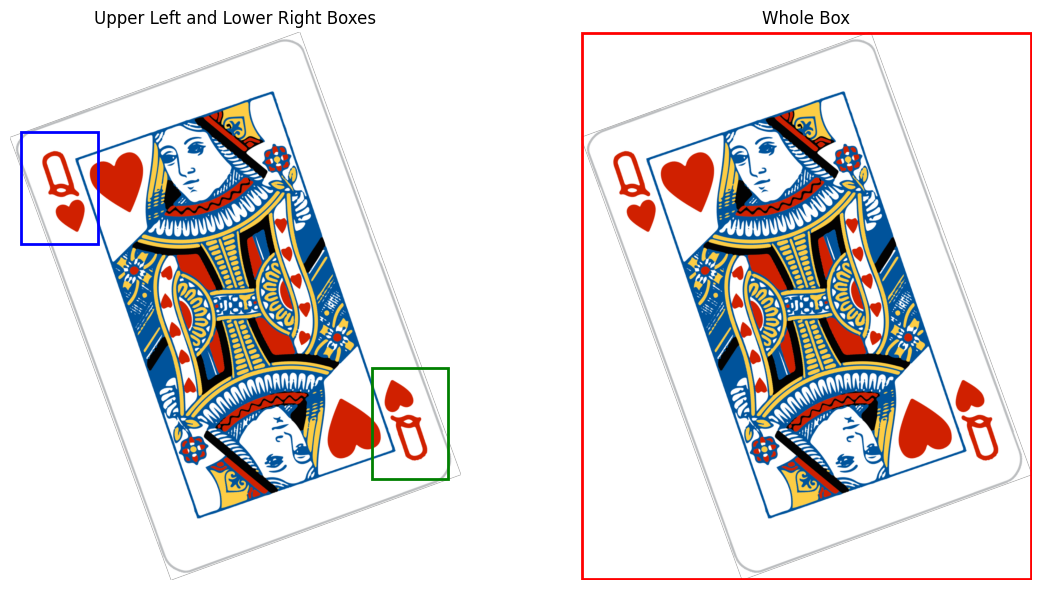

In [259]:
from matplotlib.patches import Rectangle

# Example setup (you may need to adjust paths and function definitions)
hand, flop, hand_labels, _ = deal_hand_and_flop(benchmarks_path)
hand = cv2.cvtColor(cv2.imread(hand[0]), cv2.COLOR_BGR2RGBA)

# Get rotated image and bounding boxes
angle = 20  # Use a single angle as requested
rotated_image, rotated_bb_yolo, _ = rotate_image(hand, hand_labels[0][1], angle)

# Convert YOLO notations to OpenCV notations
upper_left = tuple(yolo_notation2cv2_notation(rotated_bb_yolo[0])[0])
lower_right = tuple(yolo_notation2cv2_notation(rotated_bb_yolo[1])[0])
whole = tuple(yolo_notation2cv2_notation(rotated_bb_yolo[2])[0])

# Set up the figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Image with upper left and lower right boxes
ax1 = axes[0]
rect_upper_left = Rectangle(upper_left, rotated_bb_yolo[0][2], rotated_bb_yolo[0][3],
                            linewidth=2, edgecolor='b', facecolor='none')
rect_lower_right = Rectangle(lower_right, rotated_bb_yolo[1][2]-2, rotated_bb_yolo[1][3]-2,
                              linewidth=2, edgecolor='g', facecolor='none')
ax1.add_patch(rect_upper_left)
ax1.add_patch(rect_lower_right)
ax1.imshow(rotated_image)
ax1.set_title("Upper Left and Lower Right Boxes")
ax1.axis('off')

# Image with the whole box
ax2 = axes[1]
rect_whole = Rectangle((whole[0]+2, whole[1]+2), rotated_bb_yolo[2][2]-5, rotated_bb_yolo[2][3]-5,
                       linewidth=2, edgecolor='r', facecolor='none')
ax2.add_patch(rect_whole)
ax2.imshow(rotated_image)
ax2.set_title("Whole Box")
ax2.axis('off')

# Adjust layout and show
plt.tight_layout()
plt.show()

In [85]:
hand, flop, hand_labels, _ = deal_hand_and_flop(benchmarks_path)
hand = cv2.cvtColor(cv2.imread(hand[0]), cv2.COLOR_BGR2RGBA)

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

fig, axes = plt.subplots(3, 3, figsize=(20, 8))

angles = np.arange(-60, 75, 15)
for ax, angle in zip(axes.flatten(), angles):
    rotated_image, rotated_bb_yolo = rotate_image(hand, hand_labels[0][1], angle)
    upper_left = tuple(yolo_notation2cv2_notation(rotated_bb_yolo[0])[0])
    rect = Rectangle(upper_left, rotated_bb_yolo[0][2], rotated_bb_yolo[0][3], linewidth=1, edgecolor='b', facecolor='none')
    lower_right = tuple(yolo_notation2cv2_notation(rotated_bb_yolo[1])[0])
    rect_2 = Rectangle(lower_right, rotated_bb_yolo[1][2], rotated_bb_yolo[1][3], linewidth=1, edgecolor='b', facecolor='none')
    whole = tuple(yolo_notation2cv2_notation(rotated_bb_yolo[2])[0])
    rect_3 = Rectangle(whole, rotated_bb_yolo[2][2], rotated_bb_yolo[2][3], linewidth=1, edgecolor='b', facecolor='none')
    ax.add_patch(rect)
    ax.add_patch(rect_2)
    ax.add_patch(rect_3)
    ax.imshow(rotated_image)
    ax.set_title(f"Angle={angle} degrees")
    ax.axis('off')

plt.tight_layout()
plt.show()

### Translation of the images one next to the other

Deal with the hand case first and the flop then

In [86]:
# TODO: Implement the function to merge the cards in one image.

### Apply some shading and lighting to the images and objects ostacles on the hands

In [87]:
# TODO: Implement the function to add light and shadow effects to the merged cards.

In [88]:
def overlay_random_transparent_object(base_image: np.ndarray, object_folder: str) -> np.ndarray:
    """
    Overlays a randomly selected transparent image from `object_folder` onto `base_image`.
    Scales the object (hand) so that its height is 110% of the base image's height,
    then places it randomly in the lower 60% of the base image, allowing partial cropping.
    
    Parameters:
        base_image (np.ndarray): The base RGBA image (H x W x 4).
        object_folder (str): Path to the folder containing transparent RGBA images.
    
    Returns:
        np.ndarray: The modified RGBA image after overlay.
    """
    
    # Get a list of all files in the object folder
    object_files = [f for f in os.listdir(object_folder) if not f.startswith('.') and os.path.isfile(os.path.join(object_folder, f))]
    if not object_files:
        raise ValueError("No object files found in the given folder.")
    
    # Randomly select an object image file
    obj_file = random.choice(object_files)
    obj_path = os.path.join(object_folder, obj_file)
    
    # Load the object image with alpha channel
    obj_img = cv2.cvtColor(cv2.imread(obj_path, cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGBA) 

    # Randomly mirror the object image with 50% probability
    if random.random() < 0.5:
        obj_img = cv2.flip(obj_img, 1)  # Flip horizontally

    # Get dimensions of base and object
    base_h, base_w = base_image.shape[:2]
    obj_h, obj_w = obj_img.shape[:2]
    
    # Scale the object so that its height is 110% of the base image height
    desired_obj_h = int(1.1 * base_h)
    scale_factor = desired_obj_h / obj_h
    desired_obj_w = int(obj_w * scale_factor)
    obj_img = cv2.resize(obj_img, (desired_obj_w, desired_obj_h), interpolation=cv2.INTER_AREA)
    obj_h, obj_w = obj_img.shape[:2]

    # We want to place the object in the lower 60% of the card
    # That means y should be from 0.4 * base_h to base_h
    y_min = int(0.2 * base_h)
    y_max = base_h  # potentially placing it so that part goes below the card
    
    top_left_y = random.randint(y_min, y_max)
    
    # For x, we can allow some part to fall out of the image as well.
    # Let's choose x from a range that might allow partial clipping on either side.
    # For example, from -obj_w//2 to base_w (allow half the width to go off-screen on the left)
    x_min = -obj_w // 2
    x_max = base_w
    top_left_x = random.randint(x_min, x_max)

    # Compute the overlapping area between the object and the base image
    # Visible region in the base image
    visible_x_start = max(0, top_left_x)
    visible_y_start = max(0, top_left_y)
    visible_x_end = min(base_w, top_left_x + obj_w)
    visible_y_end = min(base_h, top_left_y + obj_h)

    # If there's no overlap, just return the base image as is
    if visible_x_end <= visible_x_start or visible_y_end <= visible_y_start:
        return base_image

    # Corresponding region in the object
    obj_x_start = visible_x_start - top_left_x
    obj_y_start = visible_y_start - top_left_y
    obj_x_end = obj_x_start + (visible_x_end - visible_x_start)
    obj_y_end = obj_y_start + (visible_y_end - visible_y_start)

    # Extract the relevant portion of the object and the alpha channel
    obj_crop = obj_img[obj_y_start:obj_y_end, obj_x_start:obj_x_end, :]
    alpha_obj = obj_crop[:, :, 3] / 255.0

    # Extract the corresponding base area
    base_crop = base_image[visible_y_start:visible_y_end, visible_x_start:visible_x_end, :]
    alpha_base = base_crop[:, :, 3] / 255.0

    # Compute the combined alpha
    combined_alpha = alpha_obj + alpha_base * (1 - alpha_obj)

    # For each color channel: R, G, B
    for c in range(3):
        base_crop[:, :, c] = (
            obj_crop[:, :, c] * alpha_obj +
            base_crop[:, :, c] * alpha_base * (1 - alpha_obj)
        ) / np.maximum(combined_alpha, 1e-6)

    # Update the alpha channel
    base_crop[:, :, 3] = (combined_alpha * 255).astype(np.uint8)

    # Put the blended region back into the base image
    base_image[visible_y_start:visible_y_end, visible_x_start:visible_x_end, :] = base_crop

    return base_image

In [89]:
# # Example usage:
# hand, flop, _, _ = deal_hand_and_flop(benchmarks_path)
# hand = cv2.cvtColor(cv2.imread(hand[0]), cv2.COLOR_BGR2RGBA)
# modified_image = overlay_random_transparent_object(hand, "../shared_data/objects")
# plt.imshow(modified_image)

### Final warping function

In [90]:
def rotate_image_3d_centered(image, image_labels, pitch, yaw, f=2000):
    """
    Rotate the image in 3D around its center and keep the center of the image stable.
    The output canvas is adjusted so the entire rotated image is visible.
    
    Parameters:
    - image: Input image as a NumPy array (H x W x 3).
    - pitch: Pitch angle in degrees (rotation around x-axis).
    - yaw:   Yaw angle in degrees (rotation around y-axis).
    - f:     Focal length for the projection (in pixels).

    Returns:
    - warped_image: The rotated image, with the center in roughly the same position 
                    and no cutoff.
    """
    h, w = image.shape[:2]

    # Image center
    cx, cy = w / 2.0, h / 2.0

    # Convert angles to radians
    pitch_rad = np.deg2rad(pitch)
    yaw_rad = np.deg2rad(yaw)

    # Rotation matrices
    R_pitch = np.array([
        [1,              0,               0           ],
        [0,  np.cos(pitch_rad), -np.sin(pitch_rad)],
        [0,  np.sin(pitch_rad),  np.cos(pitch_rad)]
    ], dtype=np.float32)

    R_yaw = np.array([
        [ np.cos(yaw_rad), 0, np.sin(yaw_rad)],
        [ 0,               1,              0],
        [-np.sin(yaw_rad), 0, np.cos(yaw_rad)]
    ], dtype=np.float32)

    # Combined rotation
    R = R_yaw @ R_pitch

    # Original corners
    original_corners_2d = np.array([[0,0],
                                    [w,0],
                                    [w,h],
                                    [0,h]], dtype=np.float32)

    corners_3d = np.array([
        [0, 0, 0],
        [w, 0, 0],
        [w, h, 0],
        [0, h, 0]
    ], dtype=np.float32)

    # Center the corners around the image center
    corners_centered = corners_3d - [cx, cy, 0]

    # Rotate corners
    rotated_corners = corners_centered @ R.T

    # Project corners
    Z = rotated_corners[:, 2] + f
    X = rotated_corners[:, 0]
    Y = rotated_corners[:, 1]

    Z[Z == 0] = 0.001
    projected_corners = np.zeros((4, 2), dtype=np.float32)
    projected_corners[:, 0] = (f * X / Z) + cx
    projected_corners[:, 1] = (f * Y / Z) + cy

    # Project the original center to see where it lands
    center_3d = np.array([[cx, cy, 0]], dtype=np.float32)
    center_centered = center_3d - [cx, cy, 0]
    center_rotated = center_centered @ R.T
    Zc = center_rotated[0, 2] + f
    Xc = center_rotated[0, 0]
    Yc = center_rotated[0, 1]
    proj_cx = (f * Xc / Zc) + cx
    proj_cy = (f * Yc / Zc) + cy

    # Compute homography
    H, _ = cv2.findHomography(original_corners_2d, projected_corners)

    # We want the projected center to remain at (cx, cy)
    # So we translate by (cx - proj_cx, cy - proj_cy)
    T_center = np.array([
        [1, 0, cx - proj_cx],
        [0, 1, cy - proj_cy],
        [0, 0, 1]
    ], dtype=np.float32)

    H_adjusted = T_center @ H

    # Apply H_adjusted to corners to find the final bounding box
    ones = np.ones((4,1), dtype=np.float32)
    corners_h = np.hstack([original_corners_2d, ones])
    transformed_corners = (H_adjusted @ corners_h.T).T
    transformed_corners = transformed_corners[:, :2] / transformed_corners[:, 2:3]

    # Compute bounding box
    all_x = transformed_corners[:, 0]
    all_y = transformed_corners[:, 1]
    min_x, max_x = np.min(all_x), np.max(all_x)
    min_y, max_y = np.min(all_y), np.max(all_y)

    new_w = int(np.ceil(max_x - min_x))
    new_h = int(np.ceil(max_y - min_y))

    # We also need to shift so that the bounding box starts at (0,0)
    # We'll add another translation to the homography
    T_box = np.array([
        [1, 0, -min_x],
        [0, 1, -min_y],
        [0, 0, 1]
    ], dtype=np.float32)

    H_final = T_box @ H_adjusted

    # Warp with final homography
    warped_image = cv2.warpPerspective(image, H_final, (new_w, new_h))

    # Warp the bounding box
    def warp_bounding_box(b_box_yolo):
        points = yolo_notation2cv2_notation(b_box_yolo)
        points_h = np.hstack([points, np.ones((points.shape[0], 1), dtype=points.dtype)])
        transformed_points_h = (H_final @ points_h.T).T

        transformed_points = transformed_points_h[:, :2] / transformed_points_h[:, 2:3]
        return cv2_modified2yolo_notation(transformed_points)

    for i, c in enumerate(image_labels):
        image_labels[i] = [c[0], [warp_bounding_box(b_box_yolo) for b_box_yolo in c[1]]]


    return warped_image, image_labels

In [91]:
# warped_image, warped_labels = rotate_image_3d_centered(canvas, labels, 30, 45)
# plt.imshow(warped_image)
# plt.axis('off')

In [92]:
# hand, flop, hand_labels, _ = deal_hand_and_flop(benchmarks_path)
# hand = cv2.cvtColor(cv2.imread(hand[0]), cv2.COLOR_BGR2RGBA)

# fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# f_values = np.arange(750, 3250, 250)
# for ax, f in zip(axes.flatten(), f_values):
#     rotated_image, rotated_bb_yolo = rotate_image_3d_centered(hand, hand_labels[0][1],pitch=-75, yaw=0, f=f)
#     upper_left = tuple(yolo_notation2cv2_notation(rotated_bb_yolo[0])[0])
#     rect = Rectangle(upper_left, rotated_bb_yolo[0][2], rotated_bb_yolo[0][3], linewidth=1, edgecolor='b', facecolor='none')
#     lower_right = tuple(yolo_notation2cv2_notation(rotated_bb_yolo[1])[0])
#     rect_2 = Rectangle(lower_right, rotated_bb_yolo[1][2], rotated_bb_yolo[1][3], linewidth=1, edgecolor='b', facecolor='none')
#     whole = tuple(yolo_notation2cv2_notation(rotated_bb_yolo[2])[0])
#     rect_3 = Rectangle(whole, rotated_bb_yolo[2][2], rotated_bb_yolo[2][3], linewidth=1, edgecolor='b', facecolor='none')
#     ax.add_patch(rect)
#     ax.add_patch(rect_2)
#     ax.add_patch(rect_3)
#     ax.imshow(rotated_image)
#     ax.set_title(f"f={int(f)}")
#     ax.axis('off')

# plt.tight_layout()
# plt.show()

# Step 2.: Add the modified Hand Cards to the background images

In [93]:
# TODO: Use all the auxiliary functions with random angles and variables to generate a synthetic hand and flop to be at the end added to a background picture.
# TODO: Modify all the functions above so to create the bounding boxes and the labels for the cards (try both oriented and non-oriented bounding boxes).

In [94]:
import cv2
import numpy as np
import random

def create_synthetic_image(image_paths):
    # Load images
    images = [cv2.imread(path) for path in image_paths]
    
    # Assuming both images have the same size
    height, width, _ = images[0].shape
    
    # Rotate each image independently
    angle1 = random.uniform(-60, 60)
    angle2 = random.uniform(-60, 60)
    
    rotated_image1 = rotate_image(images[0], angle1)
    rotated_image2 = rotate_image(images[1], angle2)
    
    # Create a new image with extra padding
    padding = 50
    new_width = width * 2 + padding * 2
    new_height = height + padding * 2
    new_image = np.ones((new_height, new_width, 3), dtype=np.uint8) * 255
    
    # Calculate random distance between centers
    max_distance = int(1.05 * width)
    min_distance = int(0.2 * width)
    distance = random.randint(min_distance, max_distance)
    
    # Place images next to each other with random distance
    x1 = padding
    y1 = padding
    x2 = x1 + distance
    y2 = padding
    
    new_image[y1:y1+height, x1:x1+width] = blurred_image1
    new_image[y2:y2+height, x2:x2+width] = blurred_image2
    
    # Use the rotate_image_3d_centered function
    # Assuming rotate_image_3d_centered is defined elsewhere and takes an image as input
    final_image = rotate_image_3d_centered(new_image)
    
    return final_image

# Example usage
# image_paths = ['path_to_image1.jpg', 'path_to_image2.jpg']
# result_image = create_synthetic_image(image_paths)
# cv2.imshow('Result Image', result_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [100]:
def scale_bounding_boxes(labels, scale_x, scale_y):
    for item in labels:
        item[1] = [(x * scale_x, y * scale_y, w * scale_x, h * scale_y) for x, y, w, h in item[1]]
    
    return labels

def translate_coordinates(labels, shift_x, shift_y):
    for item in labels:
        item[1] = [ (x + shift_x, y + shift_y, w, h) for x, y, w, h in item[1]]
    
    return labels


In [164]:
def merge_cards_background(cards_folder, background_path, objects_folder):
    temp = []
    background = cv2.cvtColor(cv2.imread(background_path, cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)
    hand, flop, hand_labels, flop_labels = deal_hand_and_flop(cards_folder)

    temp.append(cv2.cvtColor(cv2.imread(hand[0]), cv2.COLOR_BGR2RGBA))
    

    hand, trans_hand_labels = transform_merge(hand, hand_labels, objects_folder)
    pitch_hand = np.random.normal(50, 10)
    yaw_hand = np.random.randint(-45, 45)

    temp.append(hand)


    hand, final_hand_labels = rotate_image_3d_centered(hand, trans_hand_labels, pitch=pitch_hand, yaw=yaw_hand, f=2500)

    temp.append(hand)

    h_hand_new = int(np.round(hand.shape[0] /5))
    w_hand_new = int(np.round(hand.shape[1] /5))
    resized_hand = cv2.resize(hand,(w_hand_new, h_hand_new), interpolation=cv2.INTER_AREA)
    x_new = int((yaw_hand+45)/90 * (background.shape[1]-w_hand_new)) 
    y_new = np.random.randint(background.shape[0]//2, background.shape[0]-h_hand_new)

    resized_hand_labels = scale_bounding_boxes(final_hand_labels, 1/5, 1/5)
    shifted_hand_labels = translate_coordinates(resized_hand_labels, x_new, y_new)
    

    alpha = resized_hand[:, :, 3] / 255.0
    for c in range(3):
        background[y_new:y_new+h_hand_new, x_new:x_new+w_hand_new, c] = (
            resized_hand[:, :, c] * alpha +
            background[y_new:y_new+h_hand_new, x_new:x_new+w_hand_new, c] * (1.0 - alpha)
        )

    if len(flop) > 0:
        flop, trans_flop_labels = transform_merge(flop, flop_labels, objects_folder)
        yaw_flop = np.random.normal(0, 3)
        pitch_flop = np.random.randint(-75, -50)

        flop, final_flop_labels = rotate_image_3d_centered(flop, trans_flop_labels, pitch=pitch_flop, yaw=yaw_flop, f=2500)

        h_new_flop = int(np.round(flop.shape[0] / 8))
        w_new_flop = int(np.round(flop.shape[1] / 8))
        if background.shape[1] - w_new_flop <= 0:
            w_new_flop = int(np.round(flop.shape[1] // 10))
        resized_flop = cv2.resize(flop, (w_new_flop, h_new_flop), interpolation=cv2.INTER_AREA)

        x_new_flop = np.random.randint(0, background.shape[1]-w_new_flop)

        # Calculate y_new based on pitch_flop
        min_y_flop = 0
        max_y_flop = background.shape[0] // 2 - h_new_flop
        pitch_normalized_flop = (-pitch_flop - 50) / 30  # Normalize pitch to [0, 1] for range [-80, -50]
        y_new_flop = int(min_y_flop + pitch_normalized_flop * (max_y_flop - min_y_flop))

        resized_flop_labels = scale_bounding_boxes(final_flop_labels, 1/8, 1/8)
        shifted_flop_labels = translate_coordinates(resized_flop_labels, x_new_flop, y_new_flop)

        # Alpha blending for flop
        alpha_flop = resized_flop[:, :, 3] / 255.0
        for c in range(3):
            background[y_new_flop:y_new_flop+h_new_flop, x_new_flop:x_new_flop+w_new_flop, c] = (
                resized_flop[:, :, c] * alpha_flop +
                background[y_new_flop:y_new_flop+h_new_flop, x_new_flop:x_new_flop+w_new_flop, c] * (1.0 - alpha_flop)
            )
    shifted_flop_labels = 0

    temp.append(background)

    return background, shifted_hand_labels, shifted_flop_labels, temp

In [225]:
benchmarks_path = "../shared_data/benchmark"
background, hand_labels, flop_labels, temp = merge_cards_background(benchmarks_path, '../background/image_0.jpg', '../shared_data/objects')

(-0.5, 499.5, 725.5, -0.5)

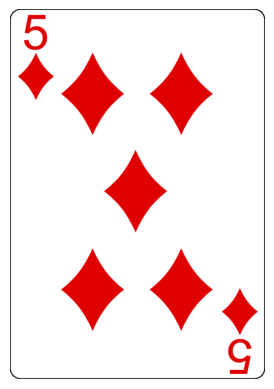

In [226]:
plt.imshow(temp[0])
plt.axis('off')

(-0.5, 1403.5, 771.5, -0.5)

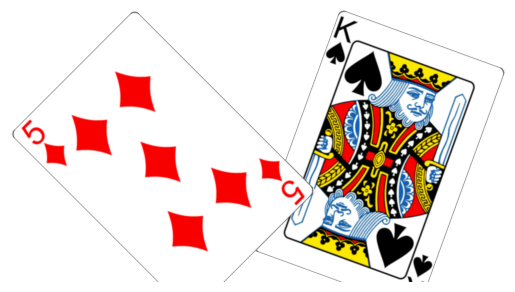

In [227]:
plt.imshow(temp[1])
plt.axis('off')

(-0.5, 1469.5, 579.5, -0.5)

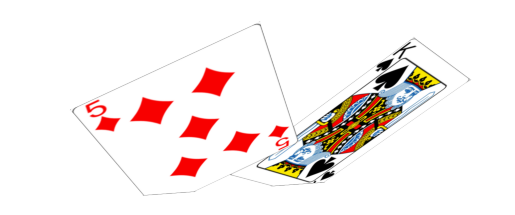

In [228]:
plt.imshow(temp[2])
plt.axis('off')

(-0.5, 639.5, 639.5, -0.5)

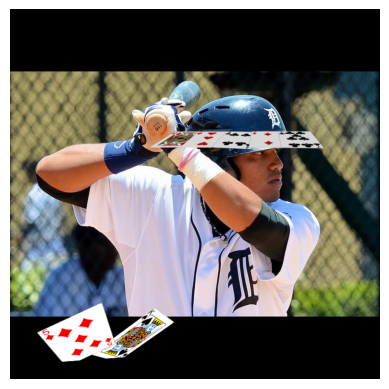

In [229]:
plt.imshow(temp[3])
plt.axis('off')